What are the most common types of bicycles stolen in toronto?
what areas are more prone to bicycle theft?
predict the timings when the risk of stolen bicycles was at the peak (days, months and years).

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import math
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import cross_val_score

In [23]:
df = pd.read_csv('bicycle-thefts - 4326.csv')

df = df.drop(['EVENT_UNIQUE_ID'], axis=1)
df = df.drop(['PRIMARY_OFFENCE'], axis=1)
df = df.drop(['REPORT_DATE'], axis=1)
df = df.drop(['REPORT_YEAR'], axis=1)
df = df.drop(['REPORT_MONTH'], axis=1)
df = df.drop(['REPORT_DAY'], axis=1)
df = df.drop(['REPORT_DOW'], axis=1)
df = df.drop(['REPORT_DOY'], axis=1)
df = df.drop(['REPORT_HOUR'], axis=1)
df = df.drop(['LOCATION_TYPE'], axis=1)
df = df.drop(['_id'], axis=1)
df = df.drop(['BIKE_MODEL'], axis=1)
df = df.drop(['OCC_DATE'], axis=1)
df = df.drop(['OCC_DAY'], axis=1)
df = df.drop(['OCC_DOY'], axis=1)
df = df.drop(['geometry'], axis=1)
df = df.drop(['OCC_YEAR'], axis=1)


In [24]:
def month_to_number(data):
    months = ["January", "February", "March","April", "May", "June",
              "July", "August", "September","October", "November", "December"]
    
    if data in months:
        return months.index(data) + 1

df['OCC_MONTH'] = df['OCC_MONTH'].apply(month_to_number)

In [25]:
def day_to_number(data):
    days = ["Monday", "Tuesday", "Wednesday", "Thursday",
            "Friday", "Saturday", "Sunday"]
    
    if data in days:
        return days.index(data) + 1

df["OCC_DOW"] = df["OCC_DOW"].apply(day_to_number)

In [26]:
ohe = OneHotEncoder()

encoded = pd.DataFrame(ohe.fit_transform(df[['PREMISES_TYPE']]).toarray())
encoded.columns = ['Apartment','House','Commercial','Outside','Transit','Educational','Other']
df = df.join(encoded)


encoded = pd.DataFrame(ohe.fit_transform(df[['BIKE_TYPE']]).toarray())
encoded.columns = ['BM','EL','FO','MT','OT','RC','RE','RG','SC','TA','TO','TR','UN']
df = df.join(encoded)

df = df.drop(['PREMISES_TYPE'], axis=1)
df = df.drop(['BIKE_TYPE'], axis=1)

In [5]:
def time_of_day(data):
    if pd.isnull(data):
        return "Unknown"
    elif data <= 4:
        return "Night"
    elif data <= 8:
        return "Dawn"
    elif data <= 11:
        return "Morning"
    elif data <= 16:
        return "Afternoon"
    elif data <= 21:
        return "Evening"
    else:
        return "Night"
    
df["OCC_TOD"] = df["OCC_HOUR"].apply(time_of_day)
df = df.drop(['OCC_HOUR'], axis=1)

In [6]:
le = LabelEncoder()

df['DIVISION'] = le.fit_transform(df['DIVISION'])
df['OCC_TOD'] = le.fit_transform(df['OCC_TOD'])
df['STATUS'] = le.fit_transform(df['STATUS'])
df['PREMISES_TYPE'] = le.fit_transform(df['PREMISES_TYPE'])
df['BIKE_TYPE'] = le.fit_transform(df['BIKE_TYPE'])

In [7]:
df['BIKE_SPEED'] = df['BIKE_SPEED'].fillna(df['BIKE_SPEED'].mean())

#Binning of BIKE_SPEED
low = df['BIKE_SPEED'].quantile(.25)
average = df['BIKE_SPEED'].quantile(.5)
high = df['BIKE_SPEED'].quantile(.75)
df['BIKE_SPEED_CATEGORY'] = np.select(
    [
        df['BIKE_SPEED'].isna(),
        df['BIKE_SPEED'] <= low,
        (df['BIKE_SPEED'] > low) & (df['BIKE_SPEED'] <= average),
        (df['BIKE_SPEED'] > average) & (df['BIKE_SPEED'] <= high),
        df['BIKE_SPEED'] > high
    ],
    [
        'NK',
        'Slow-Speeding',
        'Average-Speeding',
        'Fast-Speeding',
        'Racing'
    ],
    default='Unknown'
)

df = df.drop(['BIKE_SPEED'], axis =1)

In [8]:
low = df['BIKE_COST'].quantile(.25)
average = df['BIKE_COST'].quantile(.5)
high = df['BIKE_COST'].quantile(.75)
df['BIKE_COST_CATEGORY'] = np.select(
    [
        df['BIKE_COST'].isna(),
        df['BIKE_COST'] <= low,
        (df['BIKE_COST'] > low) & (df['BIKE_COST'] <= average),
        (df['BIKE_COST'] > average) & (df['BIKE_COST'] <= high),
        df['BIKE_COST'] > high
    ],
    [
        'NK',
        'Low',
        'Average',
        'High',
        'Luxury'
    ],
    default='Unknown'
)
df = df.drop(['BIKE_COST'], axis =1)

In [9]:
# Import the CSV with the BIKE_MAKE changes
makesData = pd.read_csv("MAKESREPLACEMENT.CSV", delimiter=";")
# Set the index as the good values and convert the strings to list
makesData.set_index("NEW", inplace=True)
makesData["OLD"] = makesData["OLD"].str.split(",")

# Convert the list to a series
makesSeries = makesData["OLD"].explode()

def GetMake(make):
    """Correct wrongfully inputted bicycle makes \n
    Parameter:
    ------------
    make: The instance bicycle make

    Return:
    -----------
    The properly written make
    """
    
    try:
        index = makesSeries.index[makesSeries.str.contains(re.escape(make))][0]
        return index
    except: 
        return make
    
df["BIKE_MAKE"] = df["BIKE_MAKE"].apply(GetMake)

In [10]:
df = df.drop(['BIKE_MAKE'], axis =1)

In [11]:
#there is one instance colored as '18' so to handle such anomalies we will replace it with unknown
df['BIKE_COLOUR'] = df['BIKE_COLOUR'].replace('18', 'Unknown')

df['BIKE_COLOUR'].fillna('Unknown', inplace=True)

In [12]:
# Function to categorize colors
def categorize_color(color):
    color = color.lower()  # Convert to lowercase for uniformity

    color_categories = {
        'black': ['black', 'blk', 'blac'],
        'blue': ['blue', 'blu'],
        'brown': ['brown', 'brn'],
        'beige': ['bge', 'beige'],
        'gold': ['gold', 'gld'],
        'green': ['green', 'grn'],
        'grey': ['grey', 'gray', 'gry'],
        'orange': ['orange', 'ong'],
        'pink': ['pink', 'pnk'],
        'purple': ['purple', 'purp'],
        'red': ['red', 'rd'],
        'silver': ['silver', 'sil'],
        'turquoise': ['turquoise', 'trq'],
        'white': ['white', 'whi'],
        'yellow': ['yellow', 'yel']
       
    }

    for category, values in color_categories.items():
        for value in values:
            if value in color:
                return category

    return 'Unknown'

df['BIKE_COLOUR'] = df['BIKE_COLOUR'].apply(categorize_color)

In [13]:
# df['BIKE_COLOUR'] = le.fit_transform(df['BIKE_COLOUR'])

In [27]:
df

OCC_MONTH  OCC_DOW  OCC_HOUR DIVISION PREMISES_TYPE   BIKE_MAKE  \
0              1        3         7      D14     Apartment  SUPERCYCLE   
1             12        4        19      D14    Commercial        FELT   
2              1        3        18      D14         House        TREK   
3              1        3        12      D52     Apartment          GI   
4             12        3        10      D51       Outside          BI   
...          ...      ...       ...      ...           ...         ...   
34285          9        5        21      D52       Transit       NORCO   
34286          9        5        23      D55         Other          OT   
34287          9        6         1      D14    Commercial          OT   
34288          9        6         6      D41         House          UK   
34289          9        5        15      D33         House        SPEC   

      BIKE_TYPE  BIKE_SPEED BIKE_COLOUR  BIKE_COST  ...   MT   OT   RC   RE  \
0            MT        10.0         NaN        NaN  ...  1.0  0.0  0.0  0.0   
1            RC        21.0      SILRED     1300.0  ...  0.0  0.0  1.0  0.0   
2            RG         1.0         BLK        NaN  ...  0.0  0.0  0.0  0.0   
3            OT         9.0         BLU     1019.0  ...  0.0  1.0  0.0  0.0   
4            TO        25.0         RED      400.0  ...  0.0  0.0  0.0  0.0   
...         ...         ...         ...        ...  ...  ...  ...  ...  ...   
34285        MT        21.0         BLK       50.0  ...  1.0  0.0  0.0  0.0   
34286        TO        15.0         TRQ     1200.0  ...  0.0  0.0  0.0  0.0   
34287        BM         1.0         GRN     2000.0  ...  0.0  0.0  0.0  0.0   
34288        RG         NaN         NaN        0.0  ...  0.0  0.0  0.0  0.0   
34289        OT         7.0         DBL        NaN  ...  0.0  1.0  0.0  0.0   

        RG   SC   TA   TO   TR   UN  
0      0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  
2      1.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  1.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  
34285  0.0  0.0  0.0  0.0  0.0  0.0  
34286  0.0  0.0  0.0  1.0  0.0  0.0  
34287  0.0  0.0  0.0  0.0  0.0  0.0  
34288  1.0  0.0  0.0  0.0  0.0  0.0  
34289  0.0  0.0  0.0  0.0  0.0  0.0  

[34290 rows x 31 columns]

In [15]:
X,y = df.drop("STATUS", axis=1), df['STATUS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

num_X = list(X.select_dtypes(exclude="object").columns)
cat_X = list(X.select_dtypes(include="object").columns)

In [16]:
clf = DecisionTreeClassifier()
# max_depth=5

In [17]:
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [18]:
#clf = clf.fit(X_train, y_train)
clf.fit(X_train_encoded, y_train)

DecisionTreeClassifier()

transformer = ColumnTransformer([('encoder', OneHotEncoder(), cat_X)], remainder='passthrough')

pipeline = Pipeline([('transformer', transformer), ('decisionTree', clf)])

pipeline_fit = pipeline.fit(X_train, y_train)

In [19]:
# y_pred = pipeline.predict(X_test)
y_pred = clf.predict(X_test_encoded)

In [20]:
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.9525614853698843


<function matplotlib.pyplot.show(close=None, block=None)>

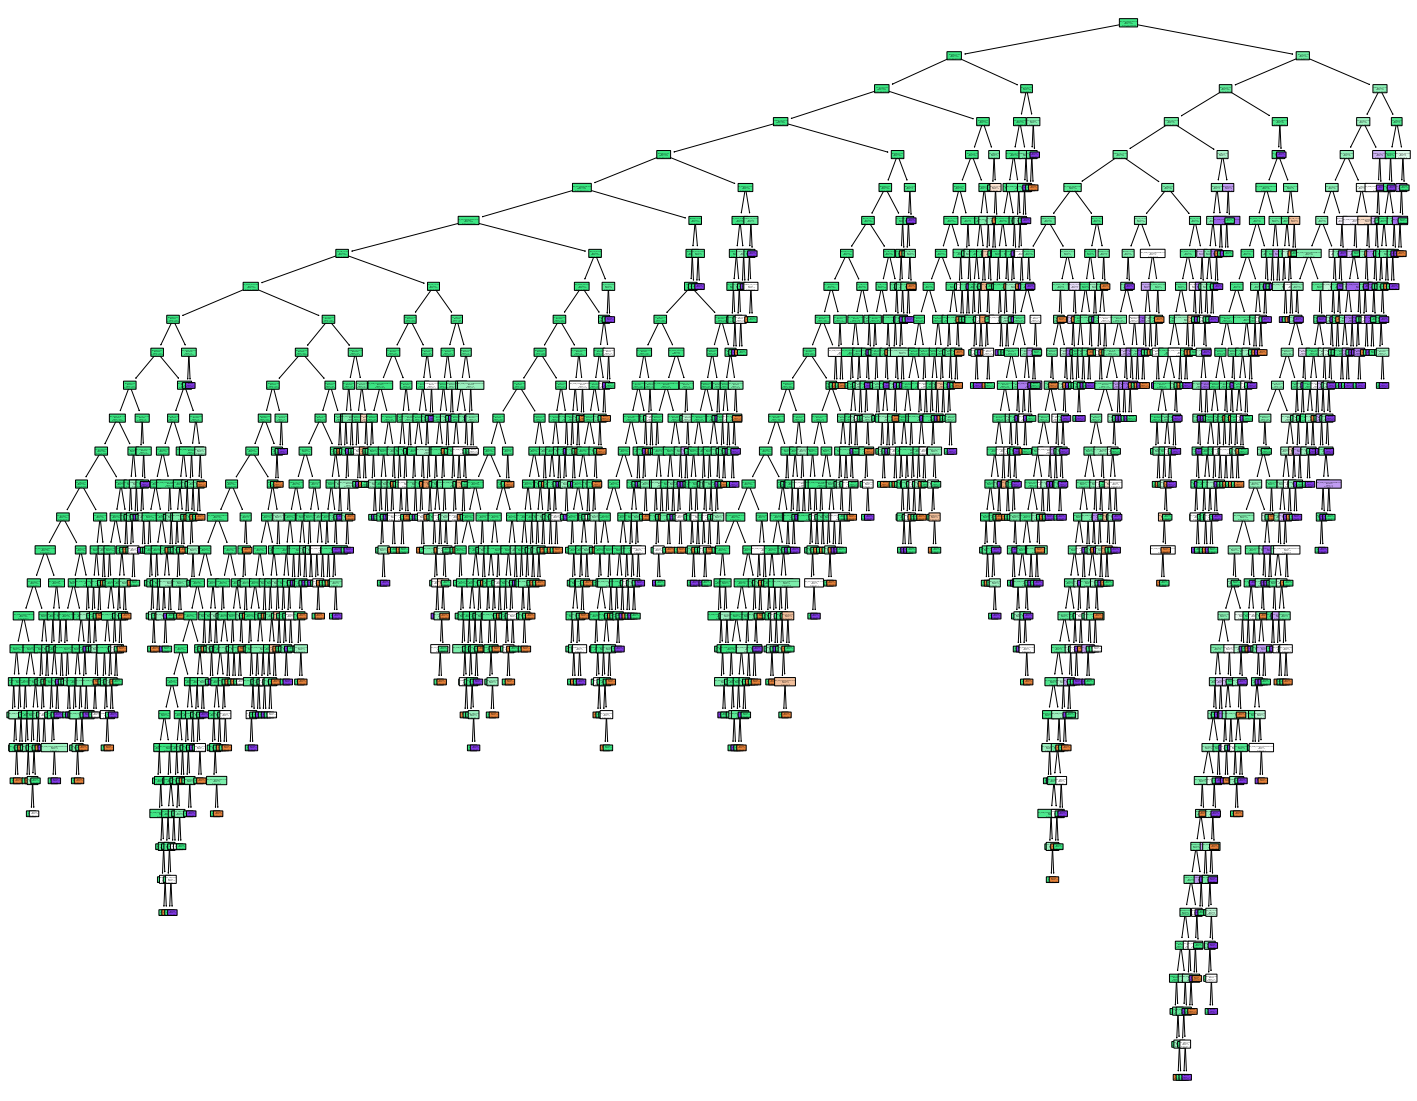

In [21]:
fig = plt.figure(figsize=(25,20))

#tree.plot_tree(pipeline['decisionTree'],filled=True,fontsize=12,feature_names=list(cat_X))
#tree.plot_tree(clf,filled=True,fontsize=12,feature_names=list(X.columns),class_names=list(str(df['STATUS'])))
tree.plot_tree(clf, filled=True, feature_names=encoder.get_feature_names_out(X_train.columns), class_names=list(str(df['STATUS'])), rounded=True)

plt.show

ValueError: could not convert string to float: 'red'